In [113]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from packages.Technical import TechnicalIndicators
from sklearn.model_selection import train_test_split
from numpy.linalg import cholesky, solve, LinAlgError
from numpy.random import default_rng


import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform



In [114]:

def fix_df(df):
    df = df.dropna(axis=1, how='all')
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df = df.set_index('date')
    else:
        df.index = pd.to_datetime(df.index, errors='coerce')
    df = df[~df.index.isna()]   
    df = df[~df.index.duplicated(keep='first')]
    df = df.sort_index()
    full_weekdays = pd.date_range(
        start=df.index.min(),
        end=df.index.max(),
        freq='B'
    )
    df = df.reindex(full_weekdays)
    return df.copy()



# BZCT = pd.read_csv('Data/BZCTCTTT_Index.csv')
KCN = pd.read_csv('Data/Coffee.csv')
BREXKD = pd.read_csv('Data/BREXKD_Index.csv')
CCEII = pd.read_csv('Data/CCEIIQTL_Index.csv')
CECDA = pd.read_csv('Data/CECDARD_Index.csv')
CECDT = pd.read_csv('Data/CECDTOTD_Index.csv')
CECFT = pd.read_csv('Data/CECFTOTV_Index.csv')
CSCIB = pd.read_csv('Data/CSCIBZTL_Index.csv')
CSCIT = pd.read_csv('Data/CSCITLTL_Index.csv')

# BZCT=fix_df(BZCT)
BREXKD= fix_df(BREXKD)
CCEII=fix_df(CCEII)   
CECDA= fix_df(CECDA)
CECDT=fix_df(CECDT)
CECFT = fix_df(CECFT)
CSCIB=fix_df(CSCIB)   
CSCIT=fix_df(CSCIT)
KCN = fix_df(KCN)

# KCN.columns    = ['KCN_' + col for col in KCN.columns]
# BZCT.columns   = ['BZCT_' + col for col in BZCT.columns]
BREXKD.columns = ['BREXKD_' + col for col in BREXKD.columns]
CCEII.columns  = ['CCEII_' + col for col in CCEII.columns]
CECDA.columns  = ['CECDA_' + col for col in CECDA.columns]
CECDT.columns  = ['CECDT_' + col for col in CECDT.columns]
CECFT.columns  = ['CECFT_' + col for col in CECFT.columns]
CSCIB.columns  = ['CSCIB_' + col for col in CSCIB.columns]
CSCIT.columns  = ['CSCIT_' + col for col in CSCIT.columns]

CECDA= CECDA.CECDA_PX_LAST
CECDT= CECDT.CECDT_PX_LAST

KCN = KCN.drop(columns=['PX_VOLUME'])
KCN = KCN.rename(columns={'PX_HIGH': 'High', 'PX_LOW': 'Low', 'PX_LAST': 'Close', 'PX_OPEN': 'KCN_PX_OPEN'})
KCN

/var/folders/0y/j6_ldsc532zgmb5tr6y2f8zm0000gn/T/ipykernel_55243/1235816459.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], errors='coerce')
/var/folders/0y/j6_ldsc532zgmb5tr6y2f8zm0000gn/T/ipykernel_55243/1235816459.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], errors='coerce')
/var/folders/0y/j6_ldsc532zgmb5tr6y2f8zm0000gn/T/ipykernel_55243/1235816459.py:4: SettingWithCopyWarning: 
A value is trying to be set on a co

,KCN_PX_OPEN,High,Low,Close
2020-04-13,118.95,120.60,116.60,119.75
2020-04-14,119.90,120.35,115.75,117.20
2020-04-15,117.00,121.20,114.60,120.20
2020-04-16,119.85,120.85,117.90,118.60
2020-04-17,118.30,119.60,115.70,116.05
...,...,...,...,...
2025-04-07,362.50,364.50,338.60,344.80
2025-04-08,345.00,350.15,340.50,342.90
2025-04-09,341.15,353.75,325.20,341.70
2025-04-10,360.10,361.50,342.15,342.85


In [115]:
data = [
    ["CSCITLTL", "ICE Total Exchange Inventories", 785559, "bag", "ICE", "4/10/2025", "Daily"],
    ["CECFTOTV", "Cecafe Brazil Monthly Exports", 3287281, "bag (69 kg)", "CECAFE", "3/31/2025", "Monthly"],
    ["CSCIBZTL", "ICE Brazil Origin Inventories", 476868, "bag (145 lb)", "ICE", "4/10/2025", "Daily"],
    ["CECDARD", "Cecafe Arabica Daily Exports", 630044, "bag (60 kg)", "CECAFE", "4/10/2025", "Daily"],
    ["BZCTCTTT", "CONAB Total Trees Estimate", 7920920, "btu", "CONAB", "1/31/2025", "Monthly"],
    ["BREXKD", "Brazil Exports by Country", 1.03E+09, "kilogram", "Brazil Ministry of Trade", "2/28/2025", "Monthly"],
    ["CECDTOTD", "Cecafe Total Daily Exports", 715430, "bag (60 kg)", "CECAFE", "4/10/2025", "Daily"],
    ["CCEIIQTL", "China Coffee Import Quantity", 14294.51, "metric tonne", "China Customs", "2/28/2025", "Monthly"]
]
columns = ["Security", "Description", "Last", "Unit", "Source", "Time", "Freq"]
df = pd.DataFrame(data, columns=columns)
df


,Security,Description,Last,Unit,Source,Time,Freq
0,CSCITLTL,ICE Total Exchange Inventories,7.855590e+05,bag,ICE,4/10/2025,Daily
1,CECFTOTV,Cecafe Brazil Monthly Exports,3.287281e+06,bag (69 kg),CECAFE,3/31/2025,Monthly
2,CSCIBZTL,ICE Brazil Origin Inventories,4.768680e+05,bag (145 lb),ICE,4/10/2025,Daily
3,CECDARD,Cecafe Arabica Daily Exports,6.300440e+05,bag (60 kg),CECAFE,4/10/2025,Daily
4,BZCTCTTT,CONAB Total Trees Estimate,7.920920e+06,btu,CONAB,1/31/2025,Monthly
5,BREXKD,Brazil Exports by Country,1.030000e+09,kilogram,Brazil Ministry of Trade,2/28/2025,Monthly
6,CECDTOTD,Cecafe Total Daily Exports,7.154300e+05,bag (60 kg),CECAFE,4/10/2025,Daily
7,CCEIIQTL,China Coffee Import Quantity,1.429451e+04,metric tonne,China Customs,2/28/2025,Monthly


Let's merge into a sigle Dataframe so we can start working with the data

In [116]:
def missing_dates_check(df, weekends=True):
    if weekends:
        full_range = pd.date_range(
            start=df.index.min(), 
            end=df.index.max(), 
            freq='D' 
        )
        missing_dates = full_range.difference(df.index)
    else:
        full_range = pd.date_range(
            start=df.index.min(), 
            end=df.index.max(), 
            freq='B' 
        )
        missing_dates = full_range.difference(df.index)
    return missing_dates

missing_dates_check(KCN, weekends=False)

DatetimeIndex([], dtype='datetime64[ns]', freq='B')

In [117]:
# dfs = [KCN, BREXKD, CCEII, CECDA, CECDT, CECFT, CSCIB, CSCIT]
dfs = [KCN, CECDA, CECDT, CSCIB, CSCIT]
merged_df = reduce(lambda left, right: pd.merge(left, right, how='outer', left_index=True, right_index=True), dfs)
missing_dates_check(merged_df, weekends=False)

# IT IS SUPER IMPORTANT TO OBSERVE THAT I USED FORWARD FILLING INSTEAD OF LINEAR INTERPOLATION
merged_df.ffill(inplace=True)
merged_df



,KCN_PX_OPEN,High,Low,Close,CECDA_PX_LAST,CECDT_PX_LAST,CSCIB_PX_LAST,CSCIT_PX_LAST
2020-04-13,118.95,120.60,116.60,119.75,123356.0,204679.0,975.0,1903323.0
2020-04-14,119.90,120.35,115.75,117.20,196711.0,288153.0,975.0,1901183.0
2020-04-15,117.00,121.20,114.60,120.20,322196.0,428597.0,975.0,1866211.0
2020-04-16,119.85,120.85,117.90,118.60,434250.0,546269.0,975.0,1866211.0
2020-04-17,118.30,119.60,115.70,116.05,507747.0,621566.0,975.0,1878805.0
...,...,...,...,...,...,...,...,...
2025-04-07,362.50,364.50,338.60,344.80,345165.0,382740.0,484858.0,773786.0
2025-04-08,345.00,350.15,340.50,342.90,2818564.0,3287281.0,484858.0,780806.0
2025-04-09,341.15,353.75,325.20,341.70,2818564.0,3287281.0,475533.0,778188.0
2025-04-10,360.10,361.50,342.15,342.85,630044.0,715430.0,476868.0,785559.0


Let's add some feautures to the dataset, namely technical indicators

In [118]:
final_df = TechnicalIndicators(merged_df)
final_df.calculate_all_indicators()
final_df = final_df.df
final_df = final_df.dropna(axis=0)
final_df 

,KCN_PX_OPEN,High,Low,Close,CECDA_PX_LAST,CECDT_PX_LAST,CSCIB_PX_LAST,CSCIT_PX_LAST,Tenkan_Sen,Kijun_Sen,...,EMA_Slow,MACD,MACD_Signal,Lowest_Low,Highest_High,%K,%D,BB_Middle,BB_Upper,BB_Lower
2020-07-29,109.40,112.60,109.30,111.60,1396757.0,1888984.0,650.0,1598138.0,104.025,103.025,...,102.603236,2.970682,1.531813,95.45,112.60,94.169096,93.729897,101.8425,112.605853,91.079147
2020-07-30,112.45,117.40,112.20,115.35,1553683.0,2087181.0,650.0,1594963.0,106.425,105.425,...,103.547441,3.530490,1.931548,95.45,117.40,90.660592,91.379288,102.4975,114.843327,90.151673
2020-07-31,116.40,119.40,115.20,118.95,1648810.0,2313251.0,650.0,1594629.0,107.425,106.425,...,104.688371,4.216032,2.388445,95.45,119.40,98.121086,94.316925,103.3325,117.701116,88.963884
2020-08-03,118.20,119.70,115.65,117.90,0.0,1000.0,650.0,1587591.0,110.475,107.575,...,105.667010,4.621331,2.835022,95.45,119.70,92.577320,93.786332,104.3675,119.817599,88.917401
2020-08-04,116.90,121.25,116.65,121.05,4579.0,5579.0,650.0,1537642.0,113.700,108.350,...,106.806491,5.137490,3.295516,95.45,121.25,99.224806,96.641070,105.4575,122.392089,88.522911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,382.05,382.15,379.35,379.05,2431864.0,2874445.0,522956.0,805588.0,404.325,391.375,...,386.695628,5.798316,13.259300,374.55,440.85,6.787330,6.837607,403.3600,442.336749,364.383251
2025-03-03,385.50,390.85,385.50,392.70,2431864.0,2874445.0,508703.0,791826.0,404.325,393.025,...,387.140396,5.385248,11.684490,374.55,440.85,27.375566,13.499246,403.9500,441.837257,366.062743
2025-03-04,391.85,404.75,391.85,403.75,2431864.0,2874445.0,508679.0,791471.0,396.225,393.825,...,388.370737,5.881731,10.523938,374.55,440.85,44.042232,26.068376,404.9700,441.599674,368.340326
2025-03-05,412.70,421.80,412.35,415.50,98932.0,108777.0,504123.0,782732.0,398.175,400.025,...,390.380312,7.141007,9.847352,374.55,438.15,64.386792,45.268197,405.8575,442.610535,369.104465


Let's now split our data up 

In [119]:
X = final_df.drop(columns=['KCN_PX_OPEN'])
y = final_df['KCN_PX_OPEN']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Building basic XGboost model

In [120]:
model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.04919657248382905,
    max_depth=3,
    random_state=40
)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")



Mean Squared Error: 5.180660637817926


Cross validation

In [121]:
# param_dist = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [3, 5, 7],
#     'learning_rate': uniform(0.01, 0.2),
#     'subsample': uniform(0.7, 0.3),
#     'colsample_bytree': uniform(0.7, 0.3)
# }

# random_search = RandomizedSearchCV(
#     model,
#     param_distributions=param_dist,
#     n_iter=20,
#     cv=5,
#     scoring='neg_mean_squared_error',
#     verbose=1,
#     n_jobs=-1,
#     random_state=42
# )

# random_search.fit(X_train, y_train)

# print("Best parameters:", random_search.best_params_)


In [122]:
importance = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)
importance_df
 

,Feature,Importance
1,Low,0.271706
10,Senkou_Span_B,0.213393
0,High,0.208182
7,Tenkan_Sen,0.147864
2,Close,0.059196
12,EMA_Fast,0.035183
17,Highest_High,0.025717
16,Lowest_Low,0.023810
8,Kijun_Sen,0.011542
13,EMA_Slow,0.001399


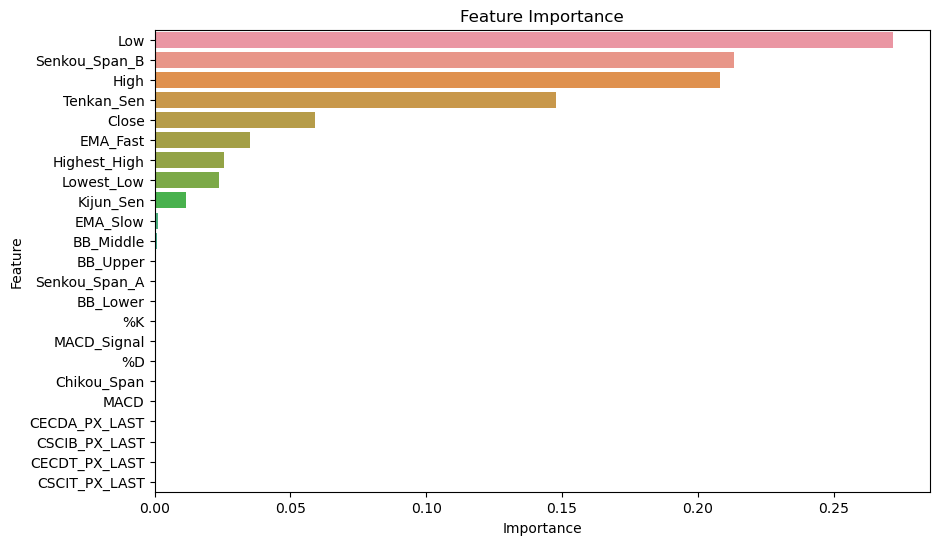

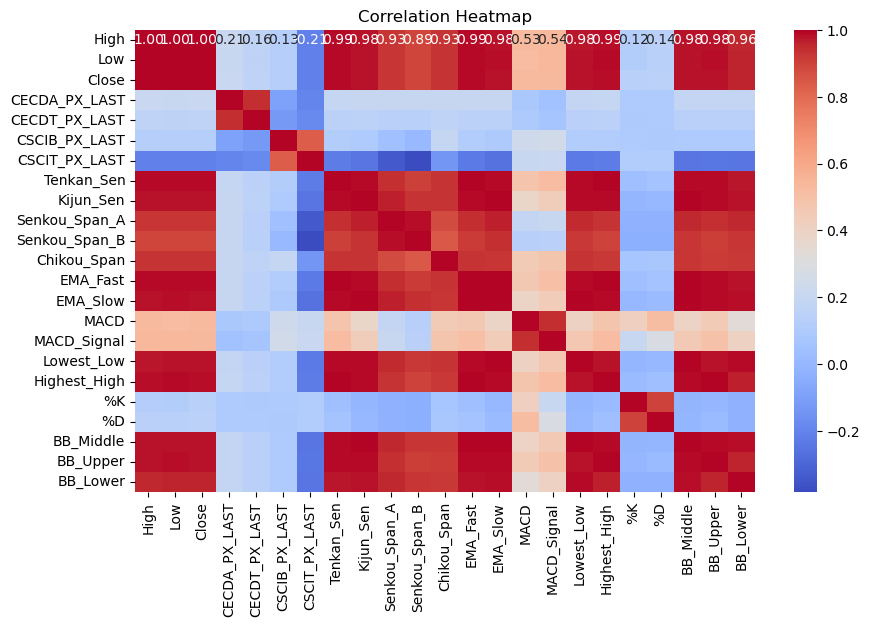

/Users/alexkoutromanos/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alexkoutromanos/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alexkoutromanos/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alexkoutromanos/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

<Axes: ylabel='KCN_PX_OPEN'>

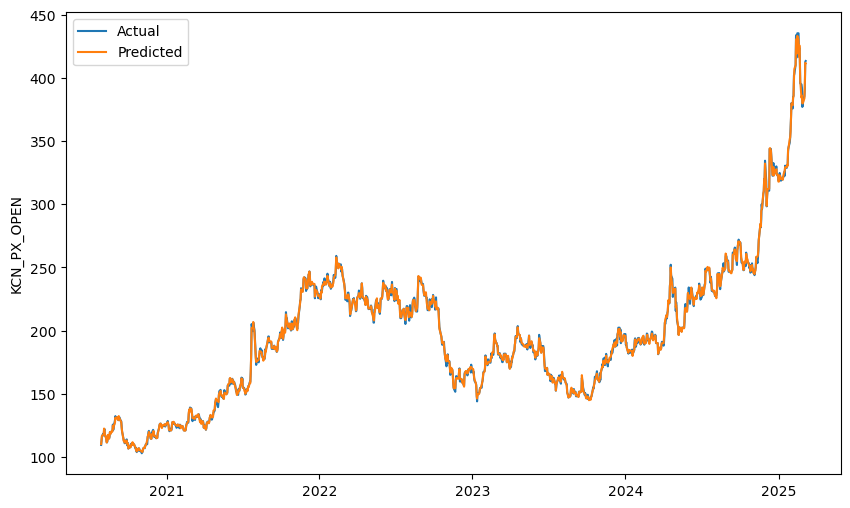

In [123]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()
plt.figure(figsize=(10, 6))
sns.heatmap(X_train.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
plt.figure(figsize=(10, 6))
sns.lineplot(data=final_df, x=final_df.index, y='KCN_PX_OPEN', label='Actual')
sns.lineplot(data=final_df, x=final_df.index, y=model.predict(X), label='Predicted') 

In [ ]:
def _sample_inv_gauss(mu, lam, rng):
    v = rng.normal()
    y = v * v
    sqrt_term = np.sqrt(4.0 * mu * lam * y + mu * mu * y * y)
    x = mu + (mu * mu * y) / (2.0 * lam) - (mu / (2.0 * lam)) * sqrt_term
    return x if rng.uniform() <= mu / (mu + x) else (mu * mu) / x


def bayesian_lasso_gibbs(
    y, X,
    n_iter=5_000, burn=1_000, thin=1, seed=None,
    eps=1e-12, tau2_floor=1e-10, mu_ig_bounds=(1e-4, 1e4)
):
    rng = default_rng(seed)


    if isinstance(X, pd.DataFrame):
        X = X.to_numpy(dtype=float, copy=False)
    else:
        X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float).ravel()
    n, p = X.shape

    # — init —
    mu, beta = y.mean(), np.zeros(p)
    sigma2, tau2, lam2 = y.var(), np.ones(p), 1.0

    XtX, ones_n = X.T @ X, np.ones(n)

    keep = (n_iter - burn) // thin
    MU, SIGMA2, LAM = np.empty(keep), np.empty(keep), np.empty(keep)
    BETA = np.empty((keep, p))
    k = 0

    for it in range(n_iter):
        # μ | ·
        r = y - X @ beta
        mu = rng.normal(r.mean(), np.sqrt(sigma2 / n))

        # β | ·
        Dinv = np.diag(1.0 / np.maximum(tau2, tau2_floor))
        try:
            Sigma_tilde = solve(XtX + Dinv, np.eye(p))
        except LinAlgError:
            Sigma_tilde = np.linalg.pinv(XtX + Dinv)
        mu_tilde = Sigma_tilde @ X.T @ (y - mu * ones_n)
        try:
            L = cholesky(Sigma_tilde * sigma2)
            beta = mu_tilde + L @ rng.normal(size=p)
        except LinAlgError:
            beta = mu_tilde + rng.multivariate_normal(
                np.zeros(p), Sigma_tilde * sigma2
            )

        # σ² | ·
        S = np.sum((y - mu - X @ beta) ** 2) + beta @ Dinv @ beta
        sigma2 = 1.0 / rng.gamma(shape=0.5 * (n + p), scale=2.0 / S)

        # τ² | ·
        abs_beta = np.abs(beta) + eps
        mu_IG = np.sqrt(lam2 * sigma2) / abs_beta
        mu_IG = np.clip(mu_IG, *mu_ig_bounds)
        tau2 = np.array([_sample_inv_gauss(m, 1.0, rng) for m in mu_IG])
        tau2 = np.maximum(tau2, tau2_floor)

        # λ² | ·
        lam2 = rng.gamma(shape=p, scale=2.0 / tau2.sum())

        # store
        if it >= burn and (it - burn) % thin == 0:
            MU[k], SIGMA2[k], LAM[k] = mu, sigma2, np.sqrt(lam2)
            BETA[k] = beta
            k += 1

    return {"mu": MU, "beta": BETA, "sigma2": SIGMA2, "lambda": LAM}


rng = default_rng(42)
samples = bayesian_lasso_gibbs(
    y_train, X_train,
    n_iter=8_000, burn=2_000, thin=5, seed=0
)
print("Posterior mean of μ :", samples["mu"].mean())
print("Posterior mean of σ²:", samples["sigma2"].mean())
print("Posterior mean of λ :", samples["lambda"].mean())

Posterior mean of μ : -1.3526681028491254
Posterior mean of σ²: 2.7366618478145384
Posterior mean of λ : 0.4635705983055663



=== Train‑set performance metrics ===
    RMSE     MAE       R2
1.641635 1.19743 0.999224


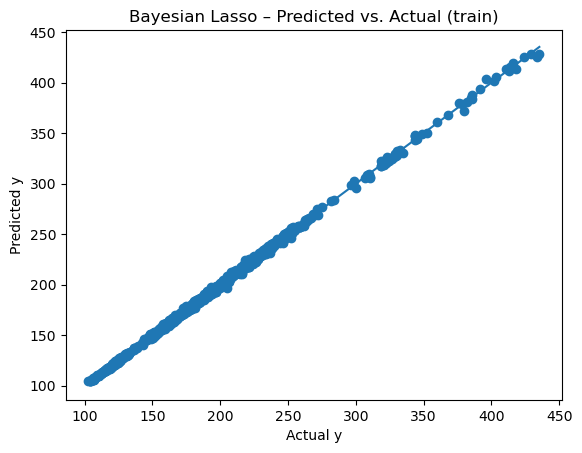

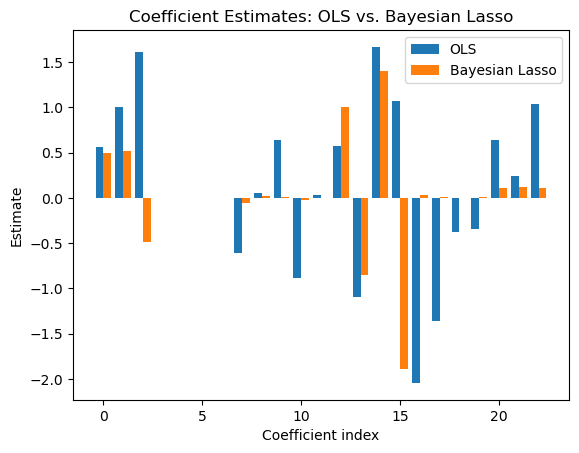

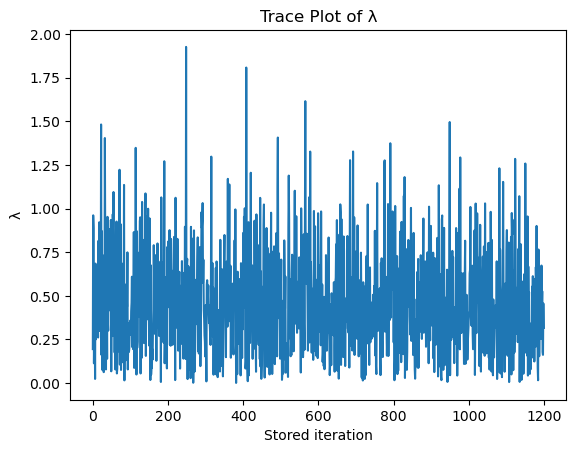

In [125]:

mu_hat   = samples["mu"].mean()
beta_hat = samples["beta"].mean(axis=0)


y_pred = mu_hat + X_train @ beta_hat

rmse = np.sqrt(np.mean((y_train - y_pred) ** 2))
mae  = np.mean(np.abs(y_train - y_pred))
r2   = 1.0 - np.sum((y_train - y_pred) ** 2) / np.sum((y_train - y_train.mean()) ** 2)

metrics_df = pd.DataFrame({"RMSE": [rmse], "MAE": [mae], "R2": [r2]})
print("\n=== Train‑set performance metrics ===")
print(metrics_df.to_string(index=False))


plt.figure()
plt.scatter(y_train, y_pred)
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()])
plt.title("Bayesian Lasso – Predicted vs. Actual (train)")
plt.xlabel("Actual y")
plt.ylabel("Predicted y")
plt.show()


beta_ols = np.linalg.lstsq(X_train, y_train - y_train.mean(), rcond=None)[0]

idx = np.arange(len(beta_hat))
plt.figure()
plt.bar(idx - 0.2, beta_ols, width=0.4, label="OLS")
plt.bar(idx + 0.2, beta_hat, width=0.4, label="Bayesian Lasso")
plt.title("Coefficient Estimates: OLS vs. Bayesian Lasso")
plt.xlabel("Coefficient index")
plt.ylabel("Estimate")
plt.legend()
plt.show()


plt.figure()
plt.plot(samples["lambda"])
plt.title("Trace Plot of λ")
plt.xlabel("Stored iteration")
plt.ylabel("λ")
plt.show()
